# Gaussian Process and Machine Learning

In [1]:
using Distributions
using LinearAlgebra
using Plots
using Printf

In [16]:
# Gaussian kernel / radial basis function
struct GaussianKernel{T <: Real}
    theta1::T
    theta2::T
    eta::Float64 # regularization parameter
    function GaussianKernel(theta1::T, theta2::T) where {T <: Real}
        theta2 == 0 ? throw(DomainError(theta2, "theta2 must not be zero")) : new{T}(theta1, theta2, 1e-6)
    end
end

# kernel function
function kernel(k::GaussianKernel, x1::Union{T, Vector{T}}, x2::Union{T, Vector{T}}) where {T <: Real}
    Base.length(x1) == Base.length(x2) || throw(DimensionMismatch("size of x1 not equal to size of x2"))
    gk.theta1 * exp(- sum(abs.(x1 - x2).^2) / gk.theta2)
end

# covariance matrix
function cov(gk::GaussianKernel, x::Union{Vector{T}, Array{T, 2}}) where {T <: Real}
    n = size(x, 1)
    c = zeros(n, n)
    for i in 1:n
        for j in 1:n
            c[i, j] = kernel(gk, x[i, :], x[j, :])
        end
    end
    # regularlize
    c += gk.eta .* Matrix{Float64}(I, n, n) 
    c
end

cov (generic function with 1 method)

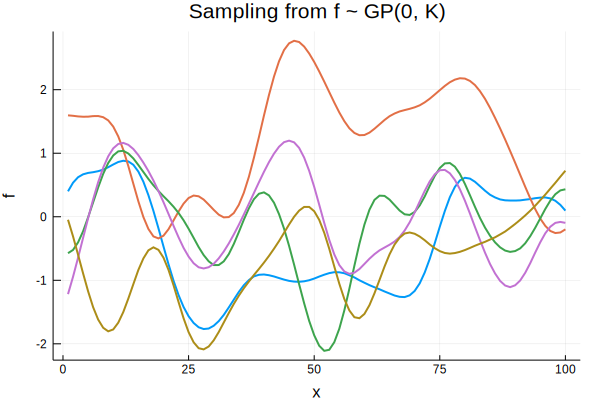

In [24]:
xx = collect(range(-5, stop = 5, length = 100))
gk = GaussianKernel(1, 1)
k = cov(gk, xx)
n = Base.length(xx)

Plots.plot(rand(MvNormal(zeros(n), k), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "Sampling from f ~ GP(0, K)")

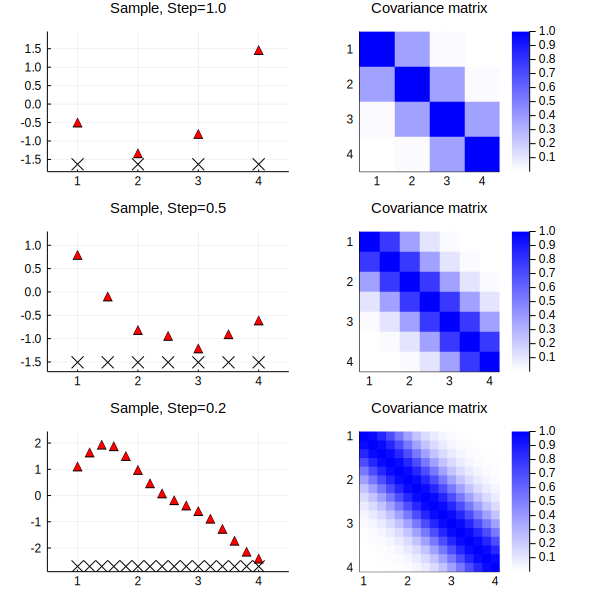

In [18]:
plts = []

xx = [1:4, 1:0.5:4, 1:0.2:4]
yy = [1, 0.5, 0.2]


for (x, y) in zip(xx, yy)
    x1 = collect(x)
    k = cov(gk, x1)
    n = Base.length(x1)
    sample = rand(MvNormal(zeros(n), k))
    sample_min = minimum(sample)
    sample_plot = scatter(x, sample, label = "",
            markershape = :utriangle, markercolor = :red,
            title = @sprintf("Sample, Step=%.1f", y), titlefontsize = 10)
    scatter!(x, fill(sample_min - 0.3, n),
        xlims = (0.5, 4.5),
        ylims = (sample_min - 0.5, maximum(sample) + 0.5),
        markershape = :x, markerstrokewidth = 2,
        label = "")
    push!(plts, sample_plot)
    push!(plts, heatmap(x1, x1, k, 
            title = "Covariance matrix", titlefontsize = 10,
            aspect_ratio = :equal, yflip = true, color = cgrad([:white, :blue])))
end

Plots.plot(plts..., layout = (3, 2), size = [600, 600])

In [148]:
x1, x2 = 0:0.05:1, 0:0.05:1
n1, n2 = Base.length(x1), Base.length(x2)
n = n1 * n2
pt = permutedims(hcat([[i, j] for i in x1, j in x2]...))
k = cov(gk, pt)
sample = rand(MvNormal(zeros(n), k))
z = reshape(sample, n1, n2)

21×21 Array{Float64,2}:
 -0.947473   -0.912768     -0.880208   …  -0.0715241  -0.00849909  0.0526067
 -0.828343   -0.794233     -0.760033      -0.0115896   0.0502923   0.112958 
 -0.707813   -0.675926     -0.647493       0.0405727   0.10526     0.168284 
 -0.585729   -0.554454     -0.528299       0.0917734   0.158062    0.219962 
 -0.467232   -0.437264     -0.4148         0.143964    0.20817     0.268972 
 -0.350307   -0.322649     -0.302042   …   0.192825    0.255153    0.319727 
 -0.236176   -0.212089     -0.193068       0.24005     0.302953    0.365932 
 -0.125133   -0.10317      -0.0896141      0.288039    0.349588    0.414321 
 -0.0203788   0.000482654   0.0130933      0.334947    0.396564    0.455338 
  0.0808421   0.0989621     0.108075       0.382535    0.442005    0.500554 
  0.176337    0.194038      0.199373   …   0.428682    0.487189    0.546259 
  0.271595    0.283117      0.288025       0.477059    0.533617    0.58775  
  0.361233    0.370741      0.373012       0.524022 

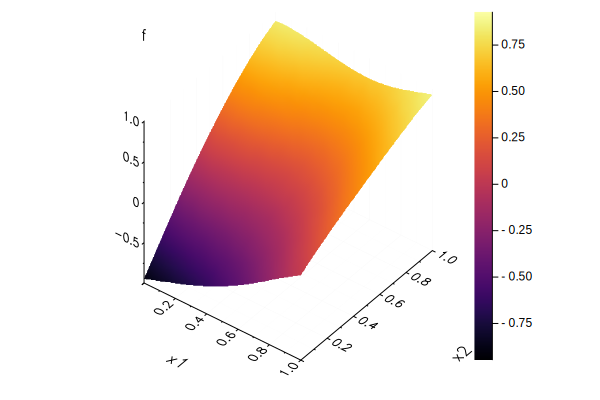

In [153]:
surface!(x1, x2, z, alpha = 0.8, camera = (40, 60),
    linewidth = 2,
    framestyle = :grid,
    xlabel = "x1", ylabel = "x2", zlabel = "f")